# DATA832 - Algorithms


# Importing Libraries

In [59]:
# Importing Libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px

# Importing Data

In [60]:
# Importing Data
df = pd.read_csv('data/Country-data.csv')




# MinMax Scaling

In [61]:
def apply_scaler(df, scaler_type='min_max'):

    if scaler_type == 'min_max':
        # Create a MinMaxScaler object
        scaler = MinMaxScaler()

    elif scaler_type == 'standard':
        # Create a StandardScaler object
        scaler = StandardScaler()

    # Fit the MinMaxScaler object
    scaler.fit(df)

    # Transform the data
    df_scaled = scaler.transform(df)

    # Create a DataFrame for the scaled data
    df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

    return scaler, df_scaled

In [62]:
# Apply MinMax scaling to the data
scaler, df_scaled = apply_scaler(df_numeric, 'min_max')

# Reducing Dimensionality with PCA

In [63]:
def apply_pca(df, n_components=None):
    # Create a PCA model
    pca = PCA(n_components=n_components)

    # Fit the PCA model
    pca.fit(df)

    # Transform the data
    pca_features = pca.transform(df)

    # Create a DataFrame for the PCA features
    pca_df = pd.DataFrame(pca_features, index=df.index, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    return pca, pca_df

In [64]:
# Apply PCA to the data
pca, df_pca = apply_pca(df_scaled, n_components=2)
df_pca['country'] = df['country']
df_pca

,PC1,PC2,country
0,-0.599078,0.095490,Afghanistan
1,0.158474,-0.212092,Albania
2,0.003686,-0.135867,Algeria
3,-0.650235,0.275975,Angola
4,0.200711,-0.064662,Antigua and Barbuda
...,...,...,...
162,-0.160078,-0.029625,Vanuatu
163,0.061133,-0.171339,Venezuela
164,0.115512,-0.032034,Vietnam
165,-0.332968,-0.019824,Yemen


# Clustering with KMeans

In [65]:
def apply_algo(df, n_clusters=3):
    # Create a KMeans model
    kmeans = KMeans(n_clusters=n_clusters)

    # Fit the KMeans model
    kmeans.fit(df.drop('country', axis=1))

    return kmeans

In [66]:
# Apply KMeans to the PCA features
kmeans = apply_algo(df_pca, n_clusters=3)
df_pca['cluster'] = kmeans.labels_
df_pca

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,PC1,PC2,country,cluster
0,-0.599078,0.095490,Afghanistan,1
1,0.158474,-0.212092,Albania,0
2,0.003686,-0.135867,Algeria,0
3,-0.650235,0.275975,Angola,1
4,0.200711,-0.064662,Antigua and Barbuda,0
...,...,...,...,...
162,-0.160078,-0.029625,Vanuatu,0
163,0.061133,-0.171339,Venezuela,0
164,0.115512,-0.032034,Vietnam,0
165,-0.332968,-0.019824,Yemen,1


In [67]:
print(df.columns)

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')


# Pipeline

In [68]:
# Create a pipeline
pipeline = {
    'scaler': 'min_max',
    'pca': 2,
    'kmeans': 3
}

In [69]:
# Function pipeline
def apply_pipeline(pipeline, df):

    # Select only numeric columns
    df_numeric = df.select_dtypes(include=['float64', 'int64'])

    # Scale the data
    scaler, df_scaled = apply_scaler(df_numeric, pipeline['scaler'])

    # Apply PCA
    pca, df_pca = apply_pca(df_scaled, n_components=pipeline['pca'])
    df_pca['country'] = df['country']

    # Apply KMeans
    kmeans = apply_algo(df_pca, n_clusters=pipeline['kmeans'])
    df_pca['cluster'] = kmeans.labels_

    return df_pca

In [70]:
# Apply the pipeline to the data
df_pca = apply_pipeline(pipeline, df)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [71]:
# Count the number of countries in each cluster
df_pca['cluster'].value_counts()


0    83
1    46
2    38
Name: cluster, dtype: int64

# Visualizing the Clusters in map

/var/folders/k1/k53d2l5d76xgyv8wbt38h3v40000gn/T/ipykernel_44987/3782665970.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


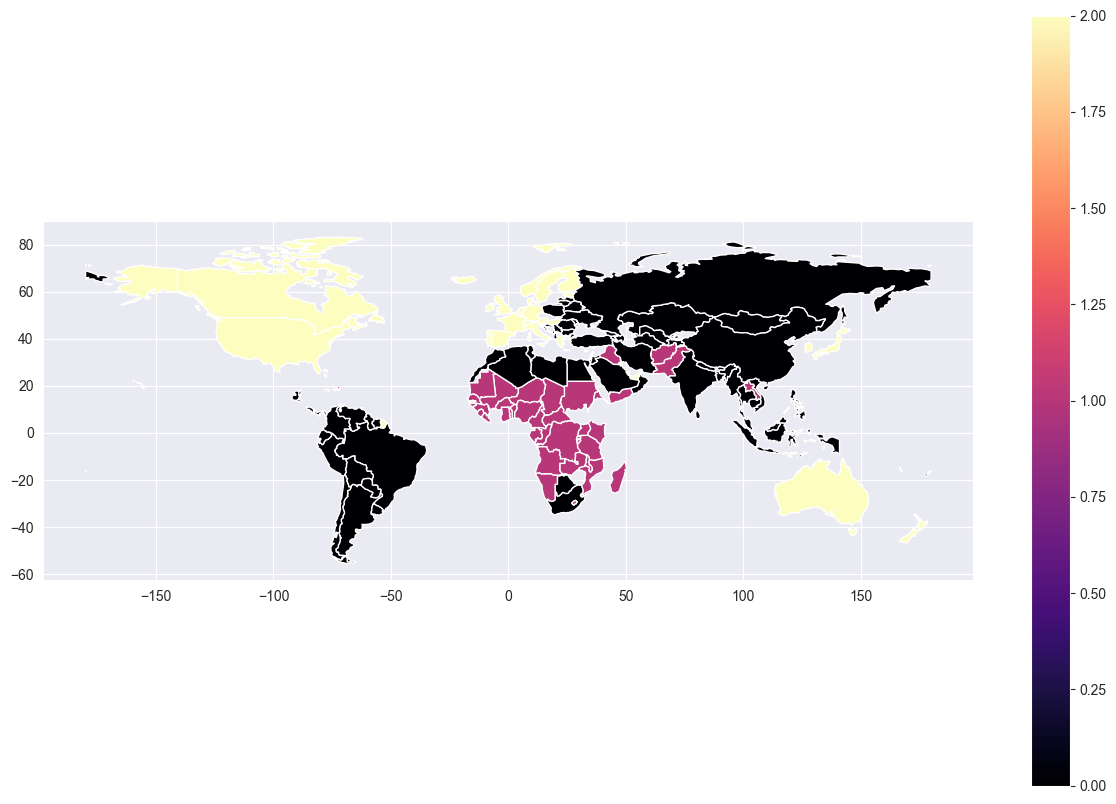

In [72]:
# Load geographic data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge geographic data with your DataFrame
merged = world.set_index('name').join(df_pca.set_index('country'))

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='cluster', ax=ax, legend=True, cmap='magma')

plt.show()